# Best RNN model - amino acid sequences

In [1]:
# Preprocessing and encoding variables
import pandas as pd
import numpy as np

# Using Skicit-learn to split data into training and testing sets
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For characterlevel one hot encoding or label encoding 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

# For creating the RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation
import tensorflow.keras.utils as utils

# For plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Tuning with keras tuner
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import HyperModel
from keras_tuner import HyperParameters

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
G = pd.read_csv('../input/genomes/G5_translated.csv').iloc[:, 1:]

In [3]:
G = G.dropna()

In [4]:
#G.shape

In [5]:
G.tail(10)

,Type,Sequence,Translated
3656,CDS,TTGATTAAAGTTGAAATGACTCCGATAAGCCCTTTACAACCTCCCA...,LIKVEMTPISPLQPPIPRSIDNRLQWGNLKGDSVSLAISTLAEKNQ...
3657,CDS,ATGTATCTAAAGACCATCAAACTTGCTGGATTCAAATCATTTGTTG...,MYLKTIKLAGFKSFVDPTLIPIRGSMNAIVGPNGCGKSNVVDAVRW...
3658,CDS,ATGGACGCCATGACTAGTTCTTCACTTTCCCTTAAAGGGTTCAGCT...,MDAMTSSSLSLKGFSFSELFTVDGLSKLDSTFLEFLKAANAVLHAR...
3659,CDS,TTGTACAGTATTATTTCCTGTATTCCGCTTCGCTCCATACGGGCTA...,LYSIISCIPLRSIRATPILLKHDDLGSRMLFLQGSHVYTPFRHQQI...
3660,CDS,GTGTACATGGCGCAAGCGAATAGTAGAAGTAGGAATTCAGCTACGA...,VYMAQANSRSRNSATISYPEKRRARVNLGKREVEILKTPYLLETQI...
3661,CDS,ATGAGATCATGGTTGTCGTTACAAGCTATTGAGAAACTGGATAAAA...,MRSWLSLQAIEKLDKKQAGEVVFSGIIEQLKKLEEFSGTKVIRFED...
3662,CDS,TTGAGAGACTTAGTAAAACAGCTAAAAAGTGAAAAACACACGGCTG...,LRDLVKQLKSEKHTAEFDALRIKLASPEEVRSWSYGEVKKPETINY...
3663,CDS,ATGCTGAGTGAACAGCGCGATGTTATTCGCGATATTATCGCCGTAC...,MLSEQRDVIRDIIAVLRKHVEVDDININHSFASLGITSLRAVQLVN...
3664,CDS,TTGAATACAGGGGTATCCATTGTGTCACATGATCATTTGACTTCGG...,LNTGVSIVSHDHLTSVDRIVEKVVTYAEKQLPKEKIALIIKFIRLY...
3665,LORF,ATGCGCAGACAACGAGATCCACAGCAGCGATTATCACTGTTTAAGC...,MRRQRDPQQRLSLFKRHEVKITDVLFLSHCIALLPREASVLLEQHK...


In [6]:
#G = G.loc[G['Dataset'] == 1]

In [7]:
#G.shape

In [8]:
#G.tail(10)

In [9]:
print('The shape of our dataframe is:', G.shape)
print('Rows:', G.shape[0])
print('Columns:', G.shape[1])

The shape of our dataframe is: (3666, 3)
Rows: 3666
Columns: 3


In [10]:
Test = G.loc[G['Type'] == 'CDS']

### Encoding data

Using sklearn OneHotEncoder and LabelEncoder

#### Labels

In [11]:
def encode_feature(array):
    """ Encode a categorical array into a number array
    
    :param array: array to be encoded
    :return: numerical array
    """
  
    encoder = preprocessing.LabelEncoder()
    encoder.fit(array)
    return encoder.transform(array)

In [12]:
class_names = ['CDS', 'LORF']
labels = G["Type"].values
print(labels)

['LORF' 'LORF' 'LORF' ... 'CDS' 'CDS' 'LORF']


In [13]:
labels = encode_feature(labels)
labels

array([1, 1, 1, ..., 0, 0, 1])

#### Sequences

The sequenes are are tokenized using keras tokenizer, then padded and finally one hot encoded.

In [14]:
# Extract sequences
samples = G['Translated'].values
samples = list(samples)
samples[0:5]

['MSIVRFQHTTQVFS*',
 'LLTRSPIPQRPLLK*',
 'LLLHQILVSPLLHRLNLKVLSKNQ*',
 'LELFFPTTSQLSFTLHLFKVLRSMKAKYPLDNLIRHKTFALSHYHYHYRFLPSWMLKRGCLKADFLLKVSLLKSPFEQCLQNLSLTNTK*',
 'VNAVIIGLPFSITL*']

In [15]:
max_len = len(max(samples, key = len))

In [16]:
# Tokenizer configured to only take into account the top-4 most common words
tokenizer = Tokenizer(char_level=True)

# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
seq_of_int = tokenizer.texts_to_sequences(samples)

In [17]:
seq_of_int[0]

[18, 4, 3, 6, 9, 11, 15, 17, 10, 10, 15, 6, 11, 4, 21]

In [18]:
print('Longest amino acid sequence is:', max_len)

Longest amino acid sequence is: 1735


In [19]:
seq_padded = sequence.pad_sequences(seq_of_int, maxlen=max_len, dtype='int32', value=0.0) # if maxlen=None then the maximum lenght is the longest sequence in genome

In [20]:
np.shape(seq_padded)

(3666, 1735)

### Create training and test data

In [21]:
# Split the data into training and testing sets -> x = features and y = labels/targets
train_x, test_x, train_y, test_y = train_test_split(seq_padded, labels, test_size = 0.25, random_state = 42)

In [22]:
print('Input data:')
print(len(train_x), 'train sequences')
print(len(test_x), 'test sequences')

Input data:
2749 train sequences
917 test sequences


### Simple LSTM model

In [23]:
input_dim = 22 # input dimension: 21 amino acids + padding

embedding_size = min(np.ceil((input_dim)/2), 50)
embedding_size = int(embedding_size)

output_dim = embedding_size
input_length = max_len

In [24]:
embedding_size

11

In [25]:
model = Sequential()
model.add(Embedding(input_dim, output_dim)) # parameter input_length not required, because no flattening needed (using RNN layer now, not Dense layer)
model.add(LSTM(288))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_x, train_y,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

2022-04-26 14:33:05.995220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:33:06.057868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:33:06.058615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 14:33:06.059721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2022-04-26 14:33:10.176064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


69/69 [==============================] - 13s 141ms/step - loss: 0.6530 - acc: 0.6403 - val_loss: 0.5695 - val_acc: 0.7545
Epoch 2/20
69/69 [==============================] - 9s 134ms/step - loss: 0.5210 - acc: 0.7713 - val_loss: 0.5085 - val_acc: 0.7655
Epoch 3/20
69/69 [==============================] - 9s 133ms/step - loss: 0.4929 - acc: 0.7744 - val_loss: 0.5302 - val_acc: 0.7455
Epoch 4/20
69/69 [==============================] - 9s 134ms/step - loss: 0.4900 - acc: 0.7754 - val_loss: 0.5014 - val_acc: 0.7709
Epoch 5/20
69/69 [==============================] - 9s 134ms/step - loss: 0.4748 - acc: 0.7799 - val_loss: 0.4980 - val_acc: 0.7636
Epoch 6/20
69/69 [==============================] - 9s 136ms/step - loss: 0.4680 - acc: 0.7885 - val_loss: 0.5132 - val_acc: 0.7455
Epoch 7/20
69/69 [==============================] - 9s 135ms/step - loss: 0.4745 - acc: 0.7790 - val_loss: 0.4929 - val_acc: 0.7618
Epoch 8/20
69/69 [==============================] - 9s 135ms/step - loss: 0.4533 - acc

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 11)          242       
_________________________________________________________________
lstm (LSTM)                  (None, 288)               345600    
_________________________________________________________________
dropout (Dropout)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 289       
Total params: 346,131
Trainable params: 346,131
Non-trainable params: 0
_________________________________________________________________


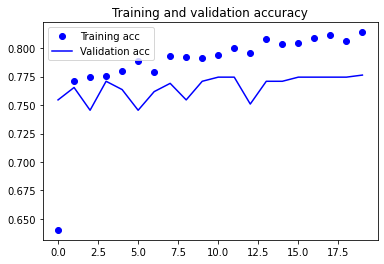

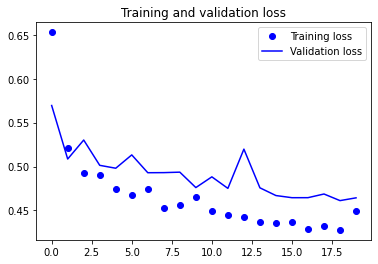

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig('tuned_acc_5_comb.png', dpi=300, bbox_inches='tight')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig('tuned_loss_5_comb.png', dpi=300, bbox_inches='tight')

plt.show()

In [28]:
scores = model.evaluate(test_x, test_y, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8167939186096191


#### Confusion matrix

In [29]:
probas = model.predict(test_x)
pred_y = (probas > 0.5).astype(np.int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [30]:
confusion_matrix(test_y, pred_y)

array([[381,  79],
       [ 89, 368]])

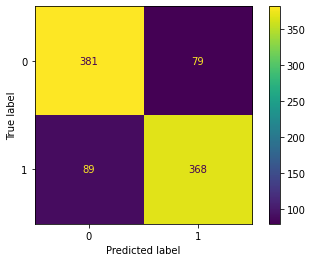

In [31]:
ConfusionMatrixDisplay.from_predictions(test_y, pred_y)